## Define the Convolutional Neural Network

After we've looked at the data we're going to be working with and, in this case, know the shapes of the images and of the keypoints, we are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

The CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

## PyTorch Neural Nets

To define a neural network in PyTorch, we define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below:

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


from models import * #to import our model
from data_load import * #to import CustomDataset and Tranforms
# import the usual resources


# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc6): Linear(in_features=12800, out_features=256

## Transform the dataset 

To prepare for training, we create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, we normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py`.

To define the data transform below, we used a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`,. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

In [4]:
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file_address='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

test_dataset = FacialKeypointsDataset(csv_file_address='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

print('Number of images: ', len(train_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = train_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model.

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True, num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [6]:
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
        
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [7]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that we applied these transformations when you loaded your test data.

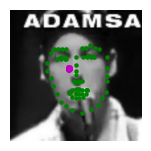

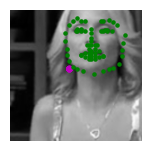

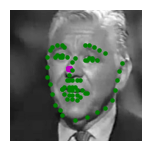

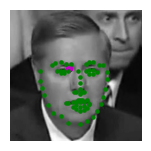

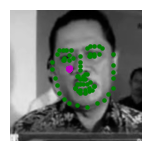

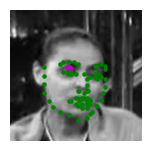

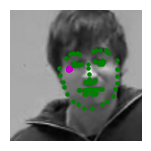

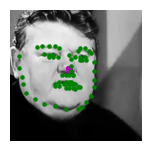

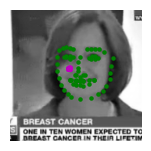

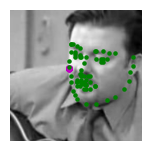

In [8]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    """
    Visualize the output by plotting a batch of images with their predicted keypoints.
    
    Args:
        test_images (Tensor): A batch of images to display.
        test_outputs (Tensor): A batch of predicted keypoints for the images.
        gt_pts (Tensor, optional): Ground truth keypoints for the images, if available.
        batch_size (int): Number of images to display in the batch.
    """

    for i in range(batch_size):
        plt.figure(figsize=(20,10))  # Create a new figure for each image in the batch with a specified size
        ax = plt.subplot(1, batch_size, i+1)  # Create a subplot in a 1x10 grid for the current image

        # Un-transform the image data
        image = test_images[i].data  # Get the image from its wrapper
        image = image.numpy()  # Convert the image tensor to a NumPy array
        image = np.transpose(image, (1, 2, 0))  # Transpose the image to convert from (C, H, W) to (H, W, C)
        image = np.squeeze(image)  # Remove any singleton dimensions, if any (useful for grayscale images)

        # Un-transform the predicted keypoints data
        predicted_key_pts = test_outputs[i].data  # Get the predicted keypoints from their wrapper
        predicted_key_pts = predicted_key_pts.numpy()  # Convert the predicted keypoints tensor to a NumPy array
        # Undo the normalization applied during preprocessing
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # Plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].data  # Get the ground truth keypoints from their wrapper
            ground_truth_pts = ground_truth_pts.numpy()  # Convert the ground truth keypoints tensor to a NumPy array
            # Undo the normalization applied during preprocessing
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # Call show_all_keypoints to display the image with keypoints
        show_all_keypoints(image, predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')  # Turn off the axis for a cleaner visualization

    plt.show()  # Display the plot with all images

visualize_output(test_images, test_outputs, gt_pts)


## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value.

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

In [9]:
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)

## Training and Initial Observation

Now, we'll train on our batched training data from `train_loader` for a number of epochs. 

In [10]:
def train_model(n_epochs: int):

    net.train()

    for epoch in range(n_epochs):
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if batch_i % 10 == 9:
                print(f"Epoch: {epoch + 1}, Batch: {batch_i + 1}, Avg.Loss: {running_loss/1000}")
                running_loss = 0.0

    print("Finished Training")

In [12]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_model(n_epochs)

Epoch: 1, Batch: 10, Avg.Loss: 0.006794575497508049
Epoch: 1, Batch: 20, Avg.Loss: 0.0024769911617040633
Epoch: 1, Batch: 30, Avg.Loss: 0.0013856524601578712
Epoch: 1, Batch: 40, Avg.Loss: 0.0010821339637041092
Epoch: 1, Batch: 50, Avg.Loss: 0.0010514012053608895
Epoch: 2, Batch: 10, Avg.Loss: 0.0008999243900179863
Epoch: 2, Batch: 20, Avg.Loss: 0.000967134341597557
Epoch: 2, Batch: 30, Avg.Loss: 0.0009818625301122666
Epoch: 2, Batch: 40, Avg.Loss: 0.0009661945402622223
Epoch: 2, Batch: 50, Avg.Loss: 0.0008989110887050629
Epoch: 3, Batch: 10, Avg.Loss: 0.001011826105415821
Epoch: 3, Batch: 20, Avg.Loss: 0.0008449778780341148
Epoch: 3, Batch: 30, Avg.Loss: 0.0008841429650783539
Epoch: 3, Batch: 40, Avg.Loss: 0.0009053382128477096
Epoch: 3, Batch: 50, Avg.Loss: 0.0008806778118014335
Epoch: 4, Batch: 10, Avg.Loss: 0.0009135122597217559
Epoch: 4, Batch: 20, Avg.Loss: 0.0009085920751094818
Epoch: 4, Batch: 30, Avg.Loss: 0.0009884747788310052
Epoch: 4, Batch: 40, Avg.Loss: 0.0009412580206990

## Test data

Here we see how our model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, we run our trained model on these images to see what kind of keypoints are produced.

In [13]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


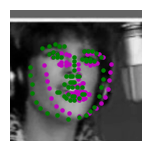

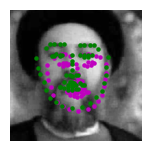

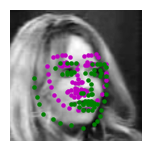

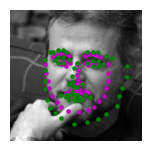

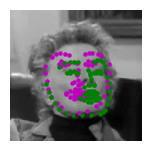

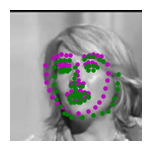

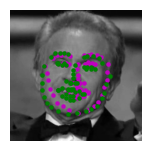

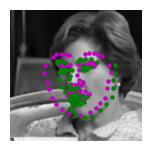

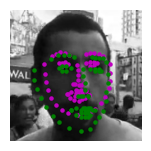

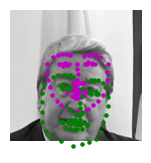

In [14]:
visualize_output(test_images, test_outputs, gt_pts)

In [15]:
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

torch.save(net.state_dict(), model_dir+model_name)

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
- For Optimization, I use Adam optimizer, because as much as knowledge I have, Adam works best for Training CNN models for its adaptive learning rate method. So for large models, Adam works better and more quickly than other optimizer like SGD, RMSProp etc.

- For Loss function I use SmoothL1Loss, because It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients, it makes ther CNN model to learn more faster

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: When designing and iterating on the network architecture presented, I began with a basic convolutional neural network (CNN) as a foundation and then progressively refined it to improve performance and robustness. Here's a detailed explanation of the thought process and changes made during the development:

- Initial Architecture:

The initial architecture was a simple CNN model with a few convolutional layers followed by fully connected layers. This base model aimed to capture essential spatial features of the input images and map them to the desired output (68 keypoints representing facial features).

- **Evolution of the Architecture**:

    1. **Increasing Convolutional Depth**:

        - **Motivation**: To capture more complex and hierarchical features from the input images, I increased the number of convolutional layers. Each additional layer allowed the network to learn progressively more abstract representations.
        - **Implementation**: I started with fewer convolutional layers and incrementally added more, eventually arriving at a deep network with five convolutional layers.
    
    2. **Batch Normalization**:

        - **Motivation**: Batch normalization helps in accelerating the training process and improving the stability of the network by normalizing the inputs of each layer. This step was crucial in mitigating issues related to internal covariate shift and speeding up convergence.
        - **Implementation**: After each convolutional layer and fully connected layer, batch normalization was added. This adjustment helped in maintaining stable and faster learning across all layers.

    3. **Pooling and Dropout Layers**:

        - **Motivation**: Max pooling layers were introduced to reduce the spatial dimensions and computational load while maintaining important features. Dropout layers were added to prevent overfitting by randomly dropping a subset of activations during training.
        - **Implementation**: Each convolutional block was followed by a max-pooling layer to down-sample the feature maps, and dropout was applied with increasing probability as the network depth increased. This strategy effectively controlled overfitting, especially in deeper layers.
    
    4. **Expanding Fully Connected Layers**:

        - **Motivation**: To bridge the gap between the high-dimensional feature maps and the final regression output (136 keypoints), I expanded the fully connected layers to process the flattened feature maps. The goal was to ensure sufficient capacity to learn complex mappings.
        - **Implementation**: I utilized two large fully connected layers before the output layer, with batch normalization and dropout included. This configuration allowed the network to handle the high-level features extracted by the convolutional layers and translate them into precise keypoint predictions.

    5. **Layer Parameters and Kernel Sizes**:

        - **Motivation**: To fine-tune the feature extraction process, different kernel sizes and layer parameters were experimented with. Smaller kernels in later layers helped in capturing finer details after initial broader feature extraction.
        - **Implementation**: The initial convolutional layer used a larger kernel size (5x5) to capture more global features, while subsequent layers employed smaller kernels (3x3) to focus on finer details.


- **Final Architecture**:
The final architecture consists of five convolutional layers, each followed by batch normalization, ReLU activation, max pooling, and dropout layers. The convolutional blocks progressively increase the number of feature maps to learn more detailed representations. Following the convolutional blocks, two fully connected layers with batch normalization and dropout precede the output layer, which predicts the 136 keypoint coordinates.

**Summary**:
Throughout the development process, the architecture evolved from a basic CNN to a deeper and more complex model, with carefully placed batch normalization and dropout layers to enhance performance and prevent overfitting. Each modification was guided by the need to balance complexity and generalization, ultimately leading to a robust network capable of accurately predicting facial keypoints.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: When deciding on the number of epochs and batch size for training the model, I focused on achieving a balance between efficient training and model performance:

1. **Number of Epochs**: I conducted preliminary experiments with various epoch counts and monitored the model's validation loss and accuracy. I aimed for enough epochs to allow the model to learn effectively without overfitting. Typically, I used early stopping based on validation performance to determine the optimal number of epochs.

2. **Batch Size**: The batch size was chosen based on available computational resources and the need for stable gradient estimates. I started with common values like 32 and 64, adjusting based on memory constraints and training stability. A larger batch size provided smoother gradients and faster convergence, but I ensured it was small enough to fit into the GPU memory.

Through iterative testing and observation, I fine-tuned these parameters to optimize training efficiency and model accuracy.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.06302626  0.1303575  -0.12445754  0.14427735 -0.15640461]
 [-0.19919093  0.04103178 -0.06731467 -0.2017249   0.18278836]
 [-0.10156134  0.0456121  -0.08531683  0.09048925  0.10342839]
 [ 0.10811891 -0.19879651  0.09479328 -0.04191425 -0.02739584]
 [-0.07451333 -0.15435976 -0.13595647  0.01661526  0.12240432]]
(5, 5)


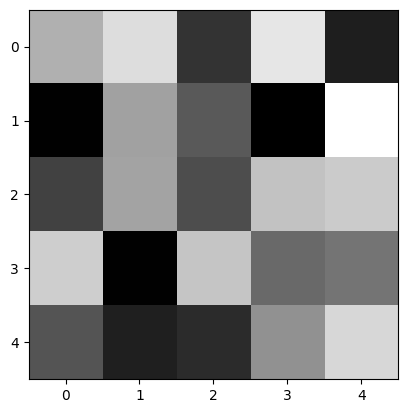

In [16]:
weights1 = net.conv1.weight.data
weights1.shape
w = weights1.numpy()
w.shape

filter_index = 20

print(w[filter_index][0])
print(w[filter_index][0].shape)

plt.imshow(w[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

## Filter an image to see the effect of a convolutional kernel
---

Text(0.5, 1.0, 'Filtered Image')

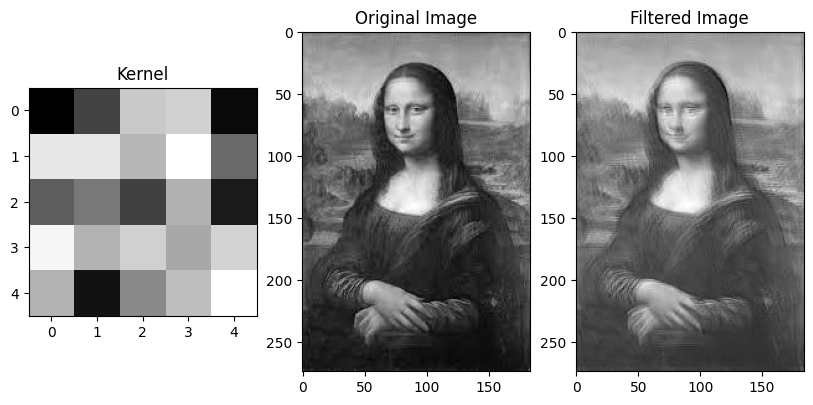

In [17]:
filter_index = 1

image = cv2.imread('images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0

w = net.conv1.weight.data.numpy()

filter_kernel = w[filter_index][0]
filtered_image = cv2.filter2D(image, -1, filter_kernel)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10,5))
ax1.imshow(filter_kernel, cmap = 'gray')
ax2.imshow(image, cmap = 'gray')
ax3.imshow(filtered_image, cmap = 'gray')

ax1.set_title("Kernel")
ax2.set_title("Original Image")
ax3.set_title("Filtered Image")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?

**Answer**: The chosen filter (filter index 1) appears to highlight edges and textures in the image. As observed in the filtered image, this convolutional kernel accentuates the boundaries and fine details, such as the contours of the Mona Lisa's face and clothing. This suggests that the filter is likely designed to detect edges or gradient changes, helping the network to identify and enhance significant structural features in the input image.

By applying this filter, we can see it effectively emphasizes these critical elements, which are essential for subsequent layers to recognize and analyze more complex patterns and shapes.